# Constellation and Chain Analysis: Prebuilt Chains

<img src="chainPaths.jpg" alt="Drawing" style="width: 500px;"/>

**Terminology**
* Node = Object in STK
* Edge = Access between two objects in STK
* Strand = The sequence of nodes and edges to complete access in a chain

**This notebook shows how to:**
* Merge access strands from chain results into one combined list
    * Example: 
        * Chain1: constellation of ground stations -> constellation of satellites -> constellation of ground stations
        * Chain2: constellation of ground stations -> constellation of satellites -> constellation of satellites -> constellation of ground stations
* Find the intervals of access for each strand, node and edge
* Find the percent of time with access vs without for each strand, node and edge
* Compute the distance and minimum time delay over time for each strand
* Find the minimum N distance/time delay strands
* Summary statistics for minimum distance and number of hops
* Load the selected strands back into STK as object lines
* Perform other network metrics such as node with most accesses, nodes with fewest hops to other nodes, nodes which connect the most other nodes
* Show network degree distributions
* Find the minimum number of nodes to remove to lose connectivity/strand access to any or all of the starting and ending nodes. (This method removes nodes along the shortest path and continuing until connectivity is lost. In some cases there may be a set of fewer nodes that could be removed to lose access to all starting and ending nodes)
* Rank nodes over time based on different connectivity metrics


In [1]:
import numpy as np
import pandas as pd
import itertools

pd.set_option("max_colwidth", 90)
from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.stkobjects import *
from agi.stk12.stkutil import *
from agi.stk12.vgt import *
import seaborn as sns
import matplotlib.pyplot as plt
from chainPathLib2 import *
import time
import networkx as nx
import warnings

warnings.filterwarnings("ignore")

## Chain Names, Computation Time and Metric

In [2]:
# Inputs for Chain Analysis
chainNames = ["Chain1Hop", "Chain2Hop"]  # Will merge results of multiple chains
start = 0  # EpSec
stop = 3600 * 1  # EpSec
metric = (
    "timeDelay"  # 'distance','timeDelay' # Other options could be add in the future
)
nodeDelays = {
    "Sats": 0.01
}  # Add in time delays. Provide the constellation name in STK and the associated node delays
stkVersion = 12  # 11 or 12

In [3]:
# Connect to STK
stkApp = STKDesktop.AttachToApplication()
stkRoot = stkApp.Root
stkRoot.UnitPreferences.SetCurrentUnit("DateFormat", "EpSec")
stkRoot.ExecuteCommand('Units_SetConnect / Date "EpochSeconds"')
stkRoot.ExecuteCommand("VO * ObjectLine DeleteAll")  # Clean up old object lines

# Build dict of node delays
nodeDelaysByNode = getNodeDelaysByNode(stkRoot, nodeDelays, chainNames=chainNames)

## Compute All Chain Strands

In [4]:
# Compute strands
t1 = time.time()
strands, dfStrands = getAllStrands(stkRoot, chainNames, start, stop)
print(time.time() - t1)
dfStrands

13.155601024627686


,strand,start,stop,dur,num hops
326,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO36, Place/Network2Place2)",0.000000,41.832715,41.832715,2.0
327,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO36, Place/Network2Place3)",0.000000,82.559212,82.559212,2.0
329,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO36, Place/Network2Place5)",0.000000,86.927976,86.927976,2.0
626,"(Place/Network1Place5, Satellite/LEO53, Satellite/LEO26, Place/Network2Place2)",0.000000,91.786642,91.786642,2.0
628,"(Place/Network1Place5, Satellite/LEO53, Satellite/LEO54, Place/Network2Place1)",0.000000,91.786642,91.786642,2.0
...,...,...,...,...,...
463,"(Place/Network1Place3, Satellite/LEO65, Satellite/LEO56, Place/Network2Place5)",3499.773384,3600.000000,100.226616,2.0
509,"(Place/Network1Place4, Satellite/LEO24, Satellite/LEO56, Place/Network2Place5)",3499.773384,3600.000000,100.226616,2.0
547,"(Place/Network1Place4, Satellite/LEO55, Satellite/LEO56, Place/Network2Place5)",3499.773384,3600.000000,100.226616,2.0
633,"(Place/Network1Place5, Satellite/LEO55, Satellite/LEO56, Place/Network2Place5)",3499.773384,3600.000000,100.226616,2.0


## Network Utilization
### Convert Strands into Nodes and Edges

In [5]:
dfNodesIntervals = getNodesIntervalsFromStrands(strands)
dfNodesIntervals

,node,start,stop,dur
0,Place/Network1Place1,0.000000,3163.905043,3163.905043
1,Place/Network1Place1,3187.514697,3600.000000,412.485303
2,Place/Network1Place2,0.000000,148.124073,148.124073
3,Place/Network1Place2,234.781044,3600.000000,3365.218956
4,Place/Network1Place3,0.000000,3600.000000,3600.000000
...,...,...,...,...
64,Satellite/LEO62,237.606363,530.313396,292.707034
65,Satellite/LEO65,2893.764793,3034.092389,140.327596
66,Satellite/LEO65,3486.634203,3600.000000,113.365797
67,Satellite/LEO66,1842.983966,2037.506307,194.522342


In [6]:
dfEdgesIntervals = getEdgesIntervalsFromStrands(strands)
dfEdgesIntervals

,edge,start,stop,dur
0,"(Place/Network1Place1, Satellite/LEO11)",655.917140,1010.813872,354.896732
1,"(Place/Network1Place1, Satellite/LEO11)",1316.734079,1484.534890,167.800811
2,"(Place/Network1Place1, Satellite/LEO12)",237.606363,433.750053,196.143691
3,"(Place/Network1Place1, Satellite/LEO15)",2894.077903,3034.092389,140.014486
4,"(Place/Network1Place1, Satellite/LEO15)",3499.773384,3586.104572,86.331188
...,...,...,...,...
222,"(Satellite/LEO65, Satellite/LEO56)",3499.773384,3600.000000,100.226616
223,"(Satellite/LEO66, Satellite/LEO24)",2719.859239,2761.919604,42.060365
224,"(Satellite/LEO66, Satellite/LEO25)",1842.983966,2037.506307,194.522342
225,"(Satellite/LEO66, Satellite/LEO34)",2435.849550,2540.364691,104.515141


### Percent of time with Access

In [7]:
dfStrandsActive = getActiveDuration(dfStrands, start, stop)
dfStrandsActive

,sum dur,% time active
strand,,
"(Place/Network1Place1, Satellite/LEO11, Satellite/LEO26, Place/Network2Place3)",166.113823,4.614273
"(Place/Network1Place1, Satellite/LEO11, Satellite/LEO26, Place/Network2Place4)",123.306273,3.425174
"(Place/Network1Place1, Satellite/LEO11, Satellite/LEO26, Place/Network2Place5)",354.896732,9.858243
"(Place/Network1Place1, Satellite/LEO11, Satellite/LEO52, Place/Network2Place3)",33.465162,0.929588
"(Place/Network1Place1, Satellite/LEO11, Satellite/LEO52, Place/Network2Place4)",20.294405,0.563733
...,...,...
"(Place/Network1Place5, Satellite/LEO56, Satellite/LEO51, Place/Network2Place5)",969.846656,26.940185
"(Place/Network1Place5, Satellite/LEO61, Satellite/LEO26, Place/Network2Place3)",29.832073,0.828669
"(Place/Network1Place5, Satellite/LEO61, Satellite/LEO26, Place/Network2Place5)",218.614983,6.072638


In [8]:
dfNodeActive = getActiveDuration(dfNodesIntervals, start, stop)
dfNodeActive

,sum dur,% time active
node,,
Place/Network1Place1,3576.390346,99.344176
Place/Network1Place2,3513.343029,97.592862
Place/Network1Place3,3600.000000,100.000000
Place/Network1Place4,3262.502942,90.625082
Place/Network1Place5,3108.421155,86.345032
Place/Network2Place1,2859.915916,79.442109
Place/Network2Place2,2771.138879,76.976080
Place/Network2Place3,3469.775587,96.382655
Place/Network2Place4,3495.672710,97.102020


In [9]:
dfEdgesActive = getActiveDuration(dfEdgesIntervals, start, stop)
dfEdgesActive

,sum dur,% time active
edge,,
"(Place/Network1Place1, Satellite/LEO11)",522.697543,14.519376
"(Place/Network1Place1, Satellite/LEO12)",196.143691,5.448436
"(Place/Network1Place1, Satellite/LEO15)",226.345674,6.287380
"(Place/Network1Place1, Satellite/LEO16)",394.482459,10.957846
"(Place/Network1Place1, Satellite/LEO21)",727.383370,20.205094
...,...,...
"(Satellite/LEO65, Satellite/LEO56)",100.226616,2.784073
"(Satellite/LEO66, Satellite/LEO24)",42.060365,1.168343
"(Satellite/LEO66, Satellite/LEO25)",194.522342,5.403398


## Path Selection

### Fewest Strand Handoffs


In [10]:
# Finds the fewest strand switches, uses a greedy first come approach
dfFewestStrandSwitches = computeFewestStrandSwitches(dfStrands, start, stop)
dfFewestStrandSwitches

,strand,start,stop,dur,num hops
40,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO26, Place/Network2Place2)",0.000000,512.973280,512.973280,2.0
139,"(Place/Network1Place3, Satellite/LEO52, Satellite/LEO53, Place/Network2Place3)",387.021023,1332.548152,945.527129,2.0
293,"(Place/Network1Place4, Satellite/LEO51, Satellite/LEO52, Place/Network2Place5)",1316.734079,2291.779605,975.045526,2.0
428,"(Place/Network1Place2, Satellite/LEO25, Satellite/LEO34, Place/Network2Place4)",2158.853515,2540.364691,381.511176,2.0
497,"(Place/Network1Place5, Satellite/LEO56, Satellite/LEO51, Place/Network2Place3)",2524.207510,3374.081400,849.873890,2.0
620,"(Place/Network1Place4, Satellite/LEO24, Satellite/LEO33, Place/Network2Place4)",3269.769466,3600.000000,330.230534,2.0


In [11]:
addStrandsAsObjectLines(stkRoot, dfFewestStrandSwitches, color="yellow")

### Minimum Distance

In [12]:
# Compute minimum distance through a chain

# Time resolution for calculating distance
step = 10  # sec

# Pull the node positions over time
t1 = time.time()
nodesTimesPos = computeNodesPosOverTime(
    stkRoot, strands, start, stop, step
)  # Pull node position over time
t2 = time.time()
print(t2 - t1)

# Discretize intervals into strands at each time
t1 = time.time()
strandsAtTimes = getStrandsAtTimes(
    strands, start, stop, step
)  # Discretize strand intervals into times
t2 = time.time()
print(t2 - t1)

# Get the position of the nodes in each strand
t1 = time.time()
timeNodePos = computeTimeNodePos(
    strandsAtTimes, nodesTimesPos
)  # Nodes and positions at each time
t2 = time.time()
print(t2 - t1)

# Compute the edges and edge distances
t1 = time.time()
timesEdgesDistancesDelays = computeTimeEdgesDistancesDelays(
    strandsAtTimes, nodesTimesPos, nodeDelaysByNode
)  # Edges, distances and delays at each time
print(time.time() - t1)

# Compute the strand distances and the minimum distance strand
t1 = time.time()
(
    timeStrandsDistances,
    dfTimesStrandsDistances,
    dfMinStrandsDistances,
) = computeTimeStrandsDistancesDelays(
    strandsAtTimes, timesEdgesDistancesDelays, start, stop, step
)  # Strands and distances at each time and minimum strand distance at each time
t2 = time.time()
print(t2 - t1)
dfMinStrandsDistances

1.4611918926239014
0.01698589324951172
0.006978034973144531
0.04085564613342285
0.07978534698486328


,time,strand,distance,time delay,num hops
0,0,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place1)",10873.329947,0.056270,2.0
1,10,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place1)",10957.046160,0.056549,2.0
2,20,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place1)",11043.945360,0.056839,2.0
3,30,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place1)",11133.958965,0.057139,2.0
4,40,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place1)",11227.010901,0.057449,2.0
...,...,...,...,...,...
356,3560,"(Place/Network1Place1, Satellite/LEO24, Satellite/LEO56, Place/Network2Place5)",9805.518010,0.052708,2.0
357,3570,"(Place/Network1Place1, Satellite/LEO24, Satellite/LEO56, Place/Network2Place5)",9821.695129,0.052762,2.0
358,3580,"(Place/Network1Place1, Satellite/LEO24, Satellite/LEO56, Place/Network2Place5)",9840.104316,0.052823,2.0
359,3590,"(Place/Network1Place1, Satellite/LEO24, Satellite/LEO56, Place/Network2Place5)",9860.751829,0.052892,2.0


In [13]:
# View intervals of minimum distance
dfIntervals = createDfIntervals(dfMinStrandsDistances, stop, step)
dfIntervals

,start,stop,dur,strand,num hops
0,0.0,125.0,125.0,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place1)",2.0
13,125.0,155.0,30.0,"(Place/Network1Place3, Satellite/LEO53, Satellite/LEO26, Place/Network2Place2)",2.0
16,155.0,235.0,80.0,"(Place/Network1Place3, Satellite/LEO53, Satellite/LEO26, Place/Network2Place3)",2.0
24,235.0,265.0,30.0,"(Place/Network1Place3, Satellite/LEO53, Place/Network2Place5)",1.0
27,265.0,525.0,260.0,"(Place/Network1Place1, Satellite/LEO21, Satellite/LEO53, Place/Network2Place5)",2.0
53,525.0,595.0,70.0,"(Place/Network1Place5, Satellite/LEO11, Satellite/LEO26, Place/Network2Place5)",2.0
60,595.0,715.0,120.0,"(Place/Network1Place5, Satellite/LEO52, Satellite/LEO26, Place/Network2Place5)",2.0
72,715.0,885.0,170.0,"(Place/Network1Place4, Satellite/LEO52, Satellite/LEO26, Place/Network2Place5)",2.0
89,885.0,985.0,100.0,"(Place/Network1Place3, Satellite/LEO52, Satellite/LEO26, Place/Network2Place5)",2.0
99,985.0,1015.0,30.0,"(Place/Network1Place3, Satellite/LEO26, Place/Network2Place5)",1.0


In [14]:
# Add shortest path to STK as object lines
t1 = time.time()
addStrandsAsObjectLines(stkRoot, dfIntervals, color="yellow")
print(time.time() - t1)

1.8679919242858887


###  Analyze Results of Minimum Distance

<AxesSubplot:xlabel='time'>

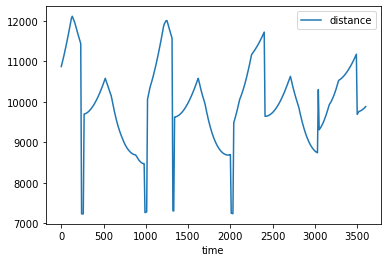

In [15]:
# View minimum strand distance over time
dfMinStrandsDistances.plot("time", "distance")

<AxesSubplot:xlabel='time'>

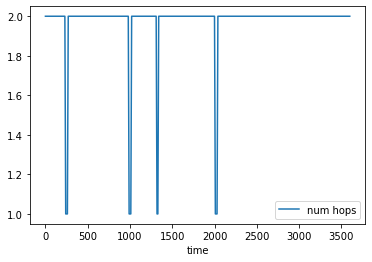

In [16]:
# View minimum strand num hops over time
dfMinStrandsDistances.plot("time", "num hops")

In [17]:
# Summary statistics for distance and num hops
dfMinStrandsDistances.describe()

,time,distance,time delay,num hops
count,361.000000,361.000000,361.000000,361.000000
mean,1800.000000,10004.892042,0.053068,1.969529
std,1043.559613,1015.083498,0.004474,0.172118
min,0.000000,7234.366831,0.034131,1.000000
25%,900.000000,9452.506601,0.051530,2.000000
50%,1800.000000,9965.400147,0.053241,2.000000
75%,2700.000000,10582.488109,0.055299,2.000000
max,3600.000000,12115.425526,0.060413,2.000000


In [18]:
# Summary stats for strand durations and num hops
dfIntervals[dfIntervals["strand"] != ""].describe()[["dur", "num hops"]]

,dur,num hops
count,31.000000,31.000000
mean,116.129032,1.870968
std,88.635110,0.340777
min,10.000000,1.000000
25%,30.000000,2.000000
50%,100.000000,2.000000
75%,160.000000,2.000000
max,310.000000,2.000000


In [19]:
# Summary stats for duration of strand gaps
dfIntervals[dfIntervals["strand"] == ""].describe()["dur"]

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: dur, dtype: float64

### Find Minimum Time Delay =  node delays + signal travel time

<AxesSubplot:xlabel='time'>

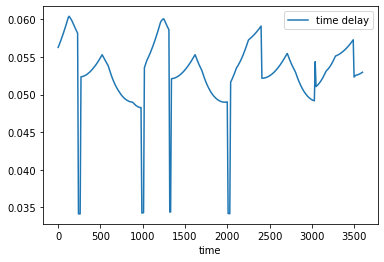

In [20]:
# Example adding node delays to look at constellation/chain latency
dfMinNStrandsTimeDelay = computeNMinMetric(dfTimesStrandsDistances, metric="time delay")
dfMinNStrandsTimeDelay.plot("time", "time delay")

In [21]:
dfIntervalsMinTimeDelay = createDfIntervals(dfMinNStrandsTimeDelay, stop, step)
addStrandsAsObjectLines(stkRoot, dfIntervalsMinTimeDelay, color="yellow")

### N Shortest

In [22]:
# Compute shortest N strands by distance
maxNumStrands = 2
dfMinNStrandsDistances = computeNMinMetric(
    dfTimesStrandsDistances, n=maxNumStrands, metric="time delay"
)
dfMinNStrandsDistances

,time,strand,distance,time delay,num hops
18,0,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place1)",10873.329947,0.056270,2.0
21,0,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place4)",10931.024615,0.056462,2.0
59,10,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place1)",10957.046160,0.056549,2.0
62,10,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place4)",11047.653044,0.056851,2.0
103,20,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place1)",11043.945360,0.056839,2.0
...,...,...,...,...,...
16023,3580,"(Place/Network1Place3, Satellite/LEO24, Satellite/LEO56, Place/Network2Place5)",10042.796865,0.053499,2.0
16033,3590,"(Place/Network1Place1, Satellite/LEO24, Satellite/LEO56, Place/Network2Place5)",9860.751829,0.052892,2.0
16041,3590,"(Place/Network1Place3, Satellite/LEO24, Satellite/LEO56, Place/Network2Place5)",10097.232214,0.053681,2.0
16050,3600,"(Place/Network1Place1, Satellite/LEO24, Satellite/LEO56, Place/Network2Place5)",9883.645506,0.052968,2.0


In [23]:
# Add best N Paths
groups = dfMinNStrandsDistances.groupby("time")
strandsMaxNumStrands = []
for numStrands in range(maxNumStrands):
    indexes = []
    for name, group in groups:
        indexes.append(group.index[numStrands])
    dfIntervalsNumStrands = createDfIntervals(
        dfMinNStrandsDistances.loc[indexes], stop, step
    )
    strandsMaxNumStrands.append(
        dfIntervalsNumStrands[["strand", "start", "stop"]].to_numpy()
    )
strandsMaxNumStrands = mergeStrands(strandsMaxNumStrands)
dfStrandsMaxNumStrands = pd.DataFrame(
    strandsMaxNumStrands, columns=["strand", "start", "stop"]
).sort_values("start")
addStrandsAsObjectLines(stkRoot, dfStrandsMaxNumStrands, color="yellow")

In [24]:
dfIntervalsNumStrands

,start,stop,dur,strand,num hops
21,0.0,65.0,65.0,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place4)",2.0
342,65.0,125.0,60.0,"(Place/Network1Place3, Satellite/LEO53, Satellite/LEO54, Place/Network2Place1)",2.0
655,125.0,135.0,10.0,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO54, Place/Network2Place1)",2.0
700,135.0,155.0,20.0,"(Place/Network1Place3, Satellite/LEO53, Satellite/LEO26, Place/Network2Place3)",2.0
759,155.0,235.0,80.0,"(Place/Network1Place3, Satellite/LEO53, Satellite/LEO26, Place/Network2Place2)",2.0
958,235.0,265.0,30.0,"(Place/Network1Place1, Satellite/LEO21, Satellite/LEO53, Place/Network2Place5)",2.0
1105,265.0,475.0,210.0,"(Place/Network1Place3, Satellite/LEO21, Satellite/LEO53, Place/Network2Place5)",2.0
2076,475.0,525.0,50.0,"(Place/Network1Place5, Satellite/LEO11, Satellite/LEO26, Place/Network2Place5)",2.0
2344,525.0,535.0,10.0,"(Place/Network1Place1, Satellite/LEO21, Satellite/LEO53, Place/Network2Place5)",2.0
2488,535.0,575.0,40.0,"(Place/Network1Place5, Satellite/LEO52, Satellite/LEO53, Place/Network2Place5)",2.0


## Use NX for Network Metrics and Reliability Analysis


In [25]:
# Get starting nodes and ending nodes of the chains
startingNodes, endingNodes = getStartingAndEndingNodes(stkRoot, chainNames)
startingNodes, endingNodes

(['Place/Network1Place4',
  'Place/Network1Place1',
  'Place/Network1Place5',
  'Place/Network1Place2',
  'Place/Network1Place3'],
 ['Place/Network2Place3',
  'Place/Network2Place5',
  'Place/Network2Place2',
  'Place/Network2Place1',
  'Place/Network2Place4'])

### Network at Time Instant

In [26]:
# Identify important nodes at a time instant
t = start
G = generateNetwork(
    t, timesEdgesDistancesDelays, timeNodePos
)  # Build network in nx, only active nodes are added

# Nodes with most Accesses/edges,score is normalized by total num edges
topNDegrees = getDegreeCentrality(G, topN=2)
print(topNDegrees)

# Nodes with fewest hops to connect to all over nodes, score is normalized
topNCloseness = getClosenessCentrality(G, topN=2)
print(topNCloseness)

# Nodes which connect the most strands between starting and ending nodes, score is normalized by connections which exist with node
startingNodesSub = [
    node for node in startingNodes if node in G.nodes()
]  # Subset of starting nodes that are active
endingNodesSub = [
    node for node in endingNodes if node in G.nodes()
]  # Subset of ending nodes that are active
topNBetweeness = getBetweennessSubsetCentrality(
    G, startingNodesSub, endingNodesSub, topN=2
)
print(topNBetweeness)

# Minimum nodes which must be removed to lose all strand accesses
nodesToRemoveAll = nodesToLoseAccess(
    G, startingNodes, endingNodes, loseAccessTo="all", topN=10
)  # Only consider the highest topN betweenness scores
print(nodesToRemoveAll)

# Minimum nodes which must be removed to lose all strand accesses
nodesToRemoveAny = nodesToLoseAccess(G, startingNodes, endingNodes, loseAccessTo="any")
print(nodesToRemoveAny)

# Shortest distance/time delay between starting and ending nodes. Already computed above, but is useful if nodes are removed
strand, metricValue = shortestStrandDistance(
    G, startingNodes, endingNodes, metric=metric
)
print(strand, metricValue)

[['Satellite/LEO54' '0.5']
 ['Satellite/LEO53' '0.5']]
[['Satellite/LEO54' '0.6666666666666666']
 ['Satellite/LEO53' '0.6363636363636364']]
[['Satellite/LEO53' '0.11941391941391943']
 ['Satellite/LEO54' '0.11575091575091576']]
[('Satellite/LEO53', 'Satellite/LEO21')]
[('Satellite/LEO53',)]
['Place/Network1Place3', 'Satellite/LEO21', 'Satellite/LEO54', 'Place/Network2Place1'] 0.05626952465677119


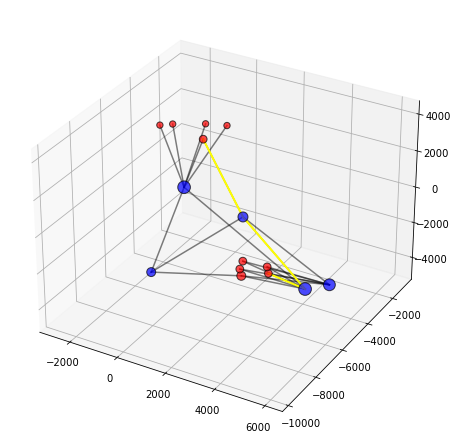

In [27]:
# # Plot nodes based on position, red is stationary, blue is moving, the larger circles indicates more accesses
network_plot_3D(G, startingNodes=startingNodes, endingNodes=endingNodes)

### Network Metrics over Time

In [28]:
# Build new networks at each time and gather metrics
t1 = time.time()
centers = []
minNumHops = []
mostEdges = []
edgeCount = []
setsOfMinNodesToRemoveAll = []
setsOfMinNodesToRemoveAny = []
minNodesToRemoveAll = []
minNodesToRemoveAny = []
degreesOfNodes = []
times = np.arange(start, stop + step, step)
for t in times:

    # Generate Network at each time
    G = generateNetwork(t, timesEdgesDistancesDelays, timeNodePos)

    # Store degree counts
    nodeNames, degrees = zip(*G.degree())
    degreesOfNodes.append(degrees)

    # Find nodes with fewest hops to all over nodes
    centers.append(nx.center(G))
    minNumHops.append(nx.radius(G) - 1)

    # Nodes with most Acceses
    maxDeg, nodesWMaxDeg = getMaxDegrees(G)
    mostEdges.append(nodesWMaxDeg)
    edgeCount.append(maxDeg)

    # Could use centrality scores instead since these are normalized
    #     nx.degree_centrality(G)
    #     nx.closeness_centrality(G)
    #     nx.betweenness_centrality_subset(G,startingNodes,endingNodes,normalized=True)

    # Min nodes to remove to lose access to all starting and ending nodes. This takes awhile to compute
    setsOfMinNodesToRemoveAll.append(
        nodesToLoseAccess(G, startingNodes, endingNodes, loseAccessTo="all", topN=10)
    )

    # Min nodes to remove to lose access to any starting or ending node. This takes awhile to compute
    setsOfMinNodesToRemoveAny.append(
        nodesToLoseAccess(G, startingNodes, endingNodes, loseAccessTo="any")
    )


time.time() - t1

6.840687036514282

In [29]:
# Put Network Metrics Over time into a df
dfNetwork = pd.DataFrame([times]).T
dfNetwork.columns = ["time"]
dfNetwork["num centers"] = pd.Series(centers).apply(lambda x: len(x))
dfNetwork["min num hops"] = minNumHops
dfNetwork["num nodes w/ max degree"] = pd.Series(mostEdges).apply(lambda x: len(x))
dfNetwork["max num edges"] = edgeCount
if setsOfMinNodesToRemoveAny:
    numSets = [len(sets) for sets in setsOfMinNodesToRemoveAll]
    lengthOfSet = [
        len(sets[0]) if len(sets) > 0 else 0 for sets in setsOfMinNodesToRemoveAll
    ]
    dfNetwork["min nodes to lose access to all"] = lengthOfSet
    dfNetwork["num of sets to lose access to all"] = numSets
if setsOfMinNodesToRemoveAny:
    numSets = [len(sets) for sets in setsOfMinNodesToRemoveAny]
    lengthOfSet = [
        len(sets[0]) if len(sets) > 0 else 0 for sets in setsOfMinNodesToRemoveAny
    ]
    dfNetwork["min nodes to lose access to any"] = lengthOfSet
    dfNetwork["num of sets to lose access to any"] = numSets
numNodes = [len(val) for key, val in timeNodePos.items()]
numEdges = [len(val) for key, val in timesEdgesDistancesDelays.items()]
numStrands = [len(val) for key, val in timeStrandsDistances.items()]
dfNetwork["tot num nodes"] = numNodes
dfNetwork["tot num edges"] = numEdges
dfNetwork["tot num strands"] = numEdges
dfNetwork.describe()

,time,num centers,min num hops,num nodes w/ max degree,max num edges,min nodes to lose access to all,num of sets to lose access to all,min nodes to lose access to any,num of sets to lose access to any,tot num nodes,tot num edges,tot num strands
count,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,1800.000000,2.531856,1.254848,1.407202,6.847645,2.094183,1.684211,0.573407,0.772853,14.700831,23.052632,23.052632
std,1043.559613,2.745645,0.436380,0.565541,0.796905,0.410953,0.806226,0.548495,0.944831,1.591374,4.509250,4.509250
min,0.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,0.000000,0.000000,9.000000,8.000000,8.000000
25%,900.000000,1.000000,1.000000,1.000000,7.000000,2.000000,1.000000,0.000000,0.000000,14.000000,21.000000,21.000000
50%,1800.000000,1.000000,1.000000,1.000000,7.000000,2.000000,1.000000,1.000000,1.000000,15.000000,23.000000,23.000000
75%,2700.000000,2.000000,2.000000,2.000000,7.000000,2.000000,2.000000,1.000000,1.000000,15.000000,25.000000,25.000000
max,3600.000000,12.000000,2.000000,4.000000,12.000000,4.000000,4.000000,2.000000,6.000000,21.000000,41.000000,41.000000


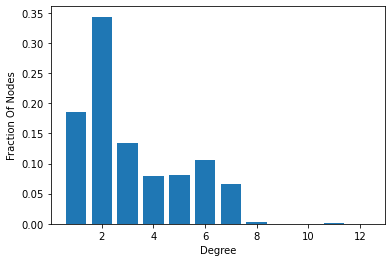

In [30]:
# Plot distribution of active node degrees over time
plotDegDistribution(degreesOfNodes)

<AxesSubplot:xlabel='time'>

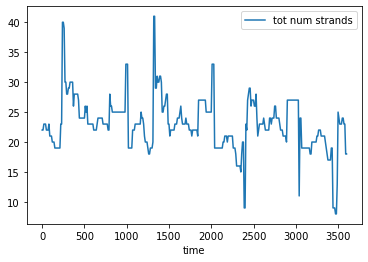

In [31]:
# Plot metric over time
dfNetwork.plot.line(x="time", y="tot num strands")

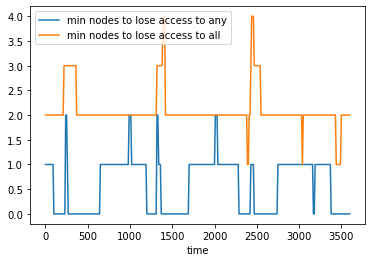

In [32]:
# Plot nodes to lose access over time
if setsOfMinNodesToRemoveAny and setsOfMinNodesToRemoveAll:
    dfNetwork.plot.line(
        x="time",
        y=["min nodes to lose access to any", "min nodes to lose access to all"],
    )

In [33]:
# Add data back into STK
t1 = time.time()
addDataToSTK(
    stkRoot, chainNames[0], dfNetwork
)  # Adds data to the first chain in the User Supplied data
print(time.time() - t1)

0.4960947036743164


## Investigating important nodes and sets of nodes over time

In [34]:
# Find node with highest average betweenness score over time
t1 = time.time()
nodesAll = {}
for t in np.arange(start, stop + step, step):
    # Generate Network at each time
    G = generateNetwork(t, timesEdgesDistancesDelays, timeNodePos)
    # Remove nodes which are not present
    startingNodesSub = [node for node in startingNodes if node in G.nodes()]
    endingNodesSub = [node for node in endingNodes if node in G.nodes()]
    # Calculate score
    nodeScores = getBetweennessSubsetCentrality(G, startingNodesSub, endingNodesSub)
    # Sum Scores
    for node, score in nodeScores:
        score = float(score)
        if node in nodesAll.keys():
            nodesAll.update({node: nodesAll[node] + score})
        else:
            nodesAll.update({node: score})
# Sort and print top scores
scores = np.asarray(list(nodesAll.items()))
scores = scores[np.argsort(scores[:, 1].astype(float)), :][::-1]
print(time.time() - t1)
scores[0:10, :]

0.11626529693603516


array([['Satellite/LEO51', '17.297407678239143'],
       ['Satellite/LEO52', '17.05509104443313'],
       ['Satellite/LEO53', '9.875335937302989'],
       ['Satellite/LEO56', '8.255398012351792'],
       ['Satellite/LEO26', '7.154038357521866'],
       ['Satellite/LEO25', '6.805066709953922'],
       ['Satellite/LEO24', '5.843198162326318'],
       ['Satellite/LEO33', '4.15591908091908'],
       ['Satellite/LEO34', '2.556922940320771'],
       ['Satellite/LEO21', '2.3296113871876805']], dtype='<U32')

In [35]:
# Number of times a node has the most edges
countNodesOverTime(mostEdges, topN=10)

array([['Satellite/LEO52', '143'],
       ['Satellite/LEO51', '120'],
       ['Satellite/LEO53', '88'],
       ['Satellite/LEO56', '36'],
       ['Satellite/LEO33', '23'],
       ['Satellite/LEO26', '22'],
       ['Satellite/LEO54', '22'],
       ['Satellite/LEO25', '19'],
       ['Satellite/LEO24', '17'],
       ['Satellite/LEO34', '11']], dtype='<U15')

In [36]:
# Number of times a set of node appears in the minimum nodes to remove all list
countNodesOverTime(setsOfMinNodesToRemoveAll, topN=10)

array([[('Satellite/LEO52', 'Satellite/LEO25'), 73],
       [('Satellite/LEO51', 'Satellite/LEO24'), 69],
       [('Satellite/LEO53', 'Satellite/LEO26'), 67],
       [('Satellite/LEO52', 'Satellite/LEO26'), 49],
       [('Satellite/LEO51', 'Satellite/LEO25'), 49],
       [('Satellite/LEO56', 'Satellite/LEO24'), 48],
       [('Satellite/LEO51', 'Satellite/LEO33'), 28],
       [('Satellite/LEO52', 'Satellite/LEO34'), 20],
       [('Satellite/LEO33', 'Satellite/LEO56'), 16],
       [('Satellite/LEO25', 'Satellite/LEO51'), 15]], dtype=object)

In [37]:
# Number of times a set of nodes appears in the minimum nodes to remove any list
countNodesOverTime(setsOfMinNodesToRemoveAny, topN=10)

array([[('Satellite/LEO51',), 59],
       [('Satellite/LEO52',), 52],
       [('Satellite/LEO53',), 44],
       [('Satellite/LEO56',), 32],
       [('Satellite/LEO24',), 23],
       [('Satellite/LEO25',), 13],
       [('Satellite/LEO26', 'Satellite/LEO53'), 5],
       [('Satellite/LEO35', 'Satellite/LEO53'), 5],
       [('Satellite/LEO25', 'Satellite/LEO52'), 5],
       [('Satellite/LEO26',), 5]], dtype=object)